# Okavango_070820 Parameter changes & Figures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import matplotlib.patches as patches
from hydroeval import evaluator, nse, rmse, pbias
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT

flopy is installed in C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\flopy


### Classify reaches based on results from a SWAT-MODFLOW_fp simulation

in a few headwater subbasins we are underestimating the amount of water detention in potholes/wetlands/impoundments/whatever..
We could increase channel bank storage or reservoir storage capacity for these subbasins/reaches when dealing with the full-fledged model. Channel Ksat values may also need to be adjusted for these reaches.\
- Increase channel bank storage or reservoir storage capacity
- Decrease Channel Ksat

### TESTING
1. CN2
    - Decrease up to minimum
        - Decreae in peak but increase in baseflow
2. SOL_AWC()
    - increase up to maximum
        - Decrease in peak and baseflow
3. ESCO()
    - increase up to maximum
        - No impact because current value is 0.95.
    - Decreae up to minimum
        - No impact (weird ...)
4. EPCO()
    - increase up to maximum
        - No impact because current value is maximum (1).
    - Decreae up to minimum
        - No impact (weird ...)
5. ESCO/EPCO settings
* To increase ET, you reduce ESCO but keep EPCO near 0.95. In principle, the lower the ESCO, the deeper soil gives up SW for soil evaporation. The higher the EPCO, the model allows soil moisture deficit for root uptake to be compensated by lower soils. As you keep both parameters low values, effects of these parameters might have been canceled out to even (from Jaehak).  
    - Base model
        - ESCO: 0.95 / EPCO: 1
    - 1st
        - ESCO: 0.095 / EPCO: 1 (selected)
    - 2nd
        - ESCO: 0.95 / EPCO: 0.01
    - 3rd
        - ESCO: 0.095 / EPCO: 0.01
### - Default SWAT parameter sets
        - ESCO: -0.9
        - OV_N: 1000
        - CH_W2.rte: -0.9
        - With MODFLOW EVT

In [2]:
from sm_pst_pkgs.sm_pst_par import riv_par
from sm_pst_pkgs.sm_pst_utils import extract_month_baseflow

# Set Path

In [3]:
wd = "E:/okvg_pp/okvg_091120_pest_man_final"
dwd = 'D:/Projects/Watersheds/Okavango/Data'
os.chdir(wd)

# Modify River parameters

In [5]:
riv_par(wd)

The "riv_package.org" file already exists...
okvg_3000.riv file is overwritten successfully!


# Run Model
# Create Dataframe

In [4]:
# Select subs
subs = [225, 240, 147]

# Create data with parameter change
df_rch = pd.read_csv(
                    os.path.join(wd, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, 6],
                    names=["date", "filter", "streamflow_sim"],
                    index_col=0)
df_adj = pd.DataFrame()
for i in subs:
    df = df_rch.loc[i]
    df = df[df["filter"] < 13]
    df.index = pd.date_range('1/1/2003', periods=len(df.streamflow_sim), freq="M")
    df.rename(columns = {'streamflow_sim':'sub_{}'.format(i)}, inplace = True)
    df_adj = pd.concat(
        [df_adj, df['sub_{}'.format(i)]], axis=1,
        sort=False
        )
df_adj.index = pd.DatetimeIndex(df_adj.index).normalize() # 3 cols
str_obd = pd.read_csv(os.path.join(wd, 'streamflow.obd'), sep='\t', index_col=0, na_values=[-999, ''], parse_dates=True) # 2 cols

df_adj = df_adj['1/1/2008':'12/31/2019']

# dff = pd.concat([df_tot[['sub_225', 'sub_240']], str_obd], axis=1, sort=False)

# Create data from base model
df_rch_org = pd.read_csv(
                    os.path.join(wd, "output.rch"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, 6],
                    names=["date", "filter", "streamflow_sim"],
                    index_col=0)
df_org = pd.DataFrame()
for i in subs:
    df = df_rch_org.loc[i]
    df = df[df["filter"] < 13]
    df.index = pd.date_range('1/1/2003', periods=len(df.streamflow_sim), freq="M")
    df.rename(columns = {'streamflow_sim':'sub_org{}'.format(i)}, inplace = True)
    df_org = pd.concat(
        [df_org, df['sub_org{}'.format(i)]], axis=1,
        sort=False
        )
df_org.index = pd.to_datetime(df.index)
df_no = df_org['1/1/2008':'12/31/2019']
df_org = df_org['1/1/2003': '12/31/2007']


# df_bau_tot_two = df_bau_tot[['sub_org225', 'sub_org240']]

# Extract Precipitation from output.std
types_dict = {'date': int, 'filter': str, 'precip': float}
df_pre_org = pd.read_csv(
                    os.path.join(wd, "output.sub"),
                    delim_whitespace=True,
                    skiprows=9,
                    usecols=[1, 3, 4],
                    names=["date", "filter", "precip"],
                    index_col=0,
                    dtype=types_dict)
df_pre_tot = pd.DataFrame()

for i in subs:
    df = df_pre_org.loc[i]
    df = df[(df['filter']).str.len() < 13]
    df.index = pd.date_range('1/1/2003', periods=len(df.precip), freq="M")
    df.rename(columns = {'precip':'pre_org{}'.format(i)}, inplace = True)
    df_pre_tot = pd.concat(
        [df_pre_tot, df['pre_org{}'.format(i)]], axis=1,
        sort=False
        )
df_pre_tot.index = pd.to_datetime(df.index)


In [7]:
extract_month_baseflow('output.sub', [66,68,147], '1/1/2003', '1/1/2003', '12/31/2007')

Average baseflow rate for 066 has been calculated ...
Average baseflow rate for 068 has been calculated ...
Average baseflow rate for 147 has been calculated ...
Finished ...



### 1. Plot for Sim vs Obd

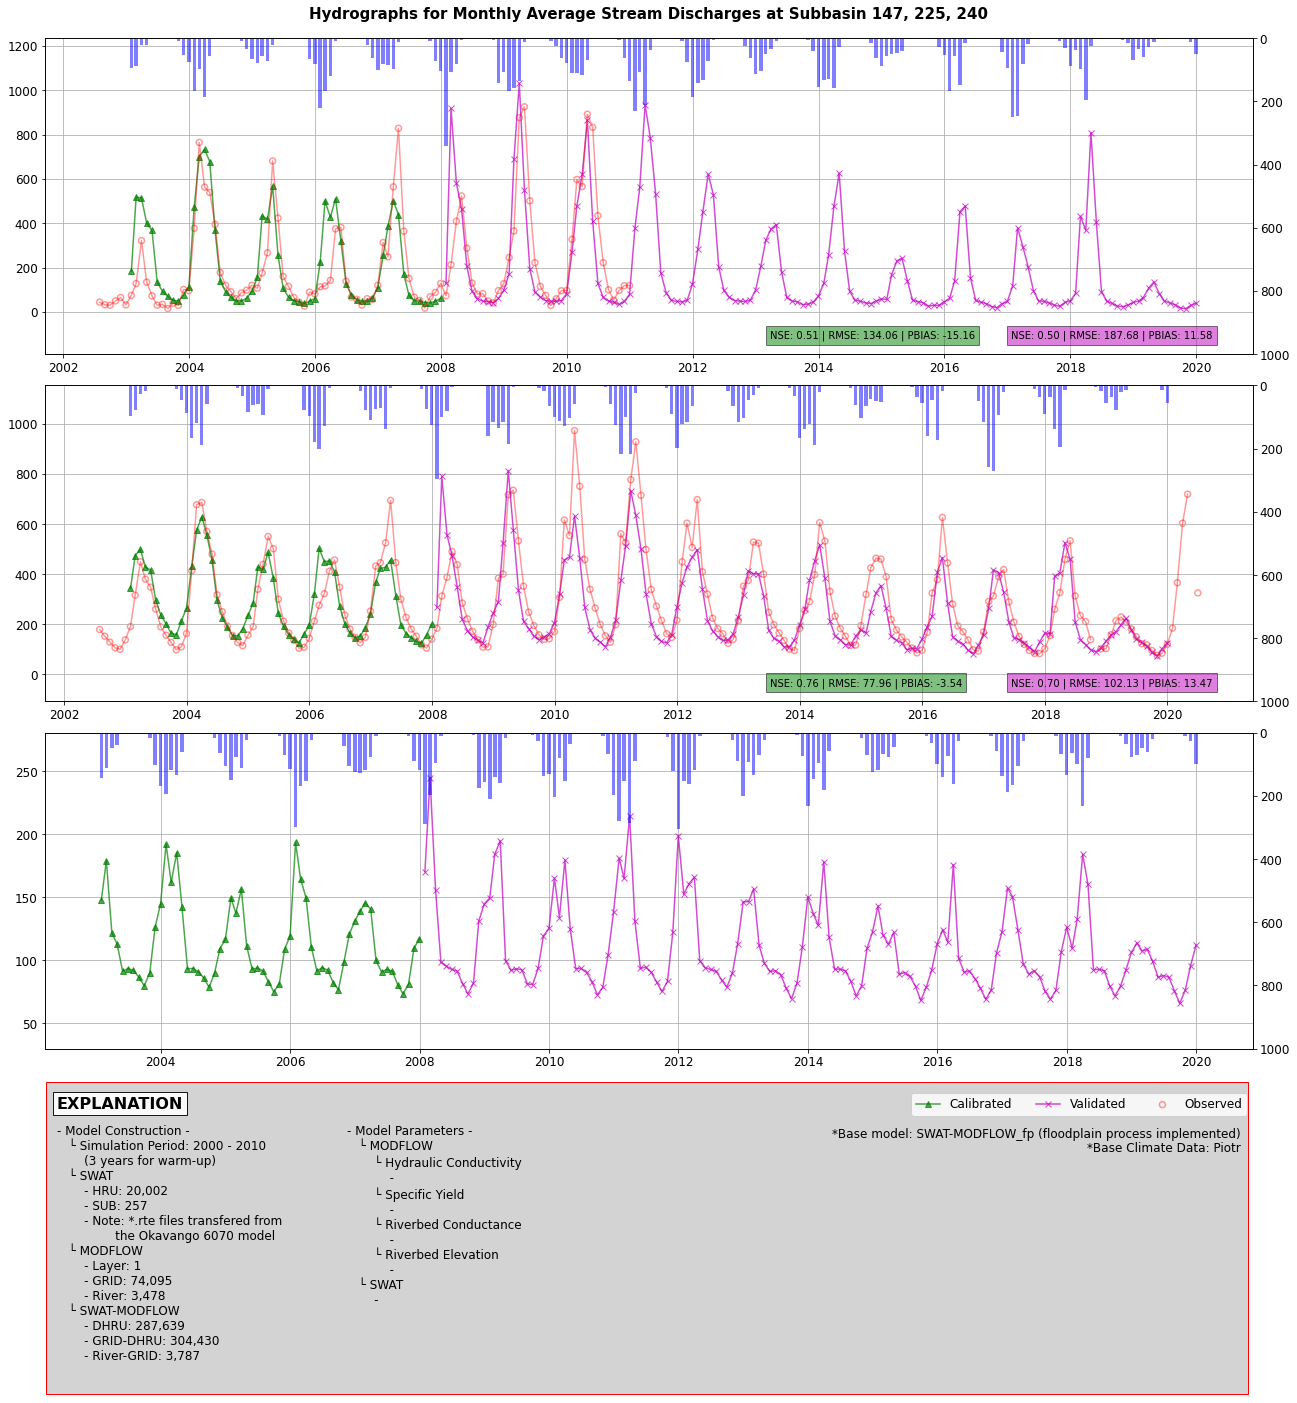

In [8]:
fig, axes = plt.subplots(
                4, 1, 
                # sharex=True,
                figsize=(18,20)
                )
ax1 = fig.add_subplot(111, frameon=False)
ax1.axis('off')
for ax, i in zip(axes, range(0, 3)):
    ax.grid(True)
    ax.plot(
        df_org.index, df_org.iloc[:, i], label='Calibrated',
        color='green', marker='^', alpha=0.7
        )
    ax.plot(
        df_adj.index, df_adj.iloc[:, i], label='Validated',
        color="m", marker="x", alpha=0.7)
    if i != 2:
        ax.scatter(
            str_obd.index, str_obd.iloc[:, i], label='Observed',
            # color='red',
            facecolors="None", edgecolors='red',
            lw=1.5,
            alpha=0.4,
            # zorder=2,
            )
        ax.plot(
            str_obd.index, str_obd.iloc[:, i],
            color='red',
            # lw=1.5,
            alpha=0.4,
            zorder=2,
            )

    ax2=ax.twinx()
    ax2.bar(
        df_pre_tot.index, df_pre_tot[df_pre_tot.columns[i]], label='Precipitation',
        width=20,
        color="blue", align='center', alpha=0.5, zorder=0)
    # ax2.set_ylabel("Precipitation $(mm)$",color="blue",fontsize=14)
    ax2.invert_yaxis()
    ax2.set_ylim(1000, 0)
    # ax2.set_yscale('log')
    ax.margins(y=0.2)
    ax.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    if i != 2:
        org_stat = pd.concat([df_org.iloc[:, i], str_obd.iloc[:, i]], axis=1, sort=False)
        org_stat = org_stat.dropna()
        # Get original statistics
        sim_org = org_stat.iloc[:, 0].to_numpy()
        obd_org = org_stat.iloc[:, 1].to_numpy()
        df_nse = evaluator(nse, sim_org, obd_org)
        df_rmse = evaluator(rmse, sim_org, obd_org)
        df_pibas = evaluator(pbias, sim_org, obd_org)
        ax.text(
            0.6, 0.05,
            'NSE: {:.2f} | RMSE: {:.2f} | PBIAS: {:.2f}'.format(df_nse[0], df_rmse[0], df_pibas[0]),
            horizontalalignment='left',fontsize=10,
            bbox=dict(facecolor='green', alpha=0.5),
            transform=ax.transAxes
            ) 

        adj_stat = pd.concat([df_adj.iloc[:, i], str_obd.iloc[:, i]], axis=1, sort=False)
        adj_stat = adj_stat.dropna()
        # Get adjusted statistics
        sim_adj = adj_stat.iloc[:, 0].to_numpy()
        obd_adj = adj_stat.iloc[:, 1].to_numpy()
        df_nse2 = evaluator(nse, sim_adj, obd_adj)
        df_rmse2 = evaluator(rmse, sim_adj, obd_adj)
        df_pibas2 = evaluator(pbias, sim_adj, obd_adj)
        ax.text(
            0.8, 0.05,
            'NSE: {:.2f} | RMSE: {:.2f} | PBIAS: {:.2f}'.format(df_nse2[0], df_rmse2[0], df_pibas2[0]),
            horizontalalignment='left',fontsize=10,
            bbox=dict(facecolor='m', alpha=0.5),
            transform=ax.transAxes
            )   
    
ax1.set_title('Hydrographs for Monthly Average Stream Discharges at Subbasin 147, 225, 240', fontsize=15, fontweight="bold", y=1.01)

# Custom individual plot
axes[2].xaxis.set_tick_params(labelbottom=True)
# axes[2].tick_params(axis='both', labelsize=12)
axes[3].axis('off')
# axes[-1, -2].axis('off')
# Create a Rectangle patch
rect = patches.Rectangle(
            (0.001, 0.001),0.995,0.23,linewidth=1,
            edgecolor='r',facecolor='lightgray'
            )
# Add the patch to the Axes
ax1.add_patch(rect)
ax1.text(
        0.01, 0.212,
        '{}'.format('EXPLANATION'),
        horizontalalignment='left',
        fontweight='bold',
        fontsize=16,
        bbox=dict(facecolor='white', alpha=0.9),
        transform=ax1.transAxes
        )
ax1.text(
        0.99, 0.19,
        '{}'.format('*Base model: SWAT-MODFLOW_fp (floodplain process implemented)'),
        horizontalalignment='right',
        # fontweight='bold',
        fontsize=12,
        # bbox=dict(facecolor='white', alpha=0.9),
        transform=ax1.transAxes
        )
ax1.text(
        0.99, 0.18,
        '{}'.format('*Base Climate Data: Piotr'),
        horizontalalignment='right',
        # fontweight='bold',
        fontsize=12,
        # bbox=dict(facecolor='white', alpha=0.9),
        transform=ax1.transAxes
        )
# Model Construction
ax1.text(
        0.01, 0.20,
        '{}'.format(
            '- Model Construction -\n' + 
            '   └ Simulation Period: 2000 - 2010\n' +
            '       (3 years for warm-up)\n' +            
            '   └ SWAT\n' + 
            '       - HRU: 20,002\n' +
            '       - SUB: 257\n' +
            '       - Note: *.rte files transfered from\n'+
            '               the Okavango 6070 model\n'+
            '   └ MODFLOW\n' + 
            '       - Layer: 1\n' +
            '       - GRID: 74,095\n' +
            '       - River: 3,478\n' +
            '   └ SWAT-MODFLOW\n' + 
            '       - DHRU: 287,639\n' +
            '       - GRID-DHRU: 304,430\n' +
            '       - River-GRID: 3,787\n'
            ),
        ha='left', va='top',
        fontsize=12,
        transform=ax1.transAxes
        )
# MODFLOW parameters
ax1.text(
        0.25, 0.20,
        '{}'.format(
            '- Model Parameters -\n' + 
            '   └ MODFLOW\n' + 
            '       └ Hydraulic Conductivity\n' + 
            '           - \n' +
            '       └ Specific Yield\n' + 
            '           - \n' +
            '       └ Riverbed Conductance\n' + 
            '           - \n' +
            '       └ Riverbed Elevation\n' + 
            '           - \n' +
            '   └ SWAT\n' + 
            '       - \n'
            ),
        ha='left', va='top',
        fontsize=12,
        transform=ax1.transAxes
        )
# Custom individual plot
# axes[0].set_ylim(-60, 550)
# axes[0].margins(y=0.6)
fig.tight_layout()
lines, labels = fig.axes[1].get_legend_handles_labels()
ax1.legend(
    lines, labels, loc = 'lower right', ncol=5,
    bbox_to_anchor=(1, 0.202),
    fontsize=12)
# plt.savefig(os.path.join(wd, 'okvg_2000_set7.png'), dpi=300)
plt.show()


In [116]:
365*203

74095

In [117]:
import math

a = 7.03493E+06
math.sqrt(a)

2652.344246133974